# Log Sum Exp 関数

---

今回は強化学習に使われる関数のLog Sum Exp関数の紹介していきたいと思います．

この関数がいつ使われるかというと，例えば，ロバスト強化学習では次のような式で価値関数の更新をしていきます．

$$
V^\pi(s) \triangleq \max _{\kappa \in \bigotimes_{t \geq 0} \mathcal{P}} \mathbb{E}_\kappa\left[\sum_{t=0}^{\infty} \gamma^t c\left(S_t, A_t\right) \mid S_0=s, \pi\right]
$$

$$
\sigma_{\mathcal{P}_s}(V)=(1-R) \sum_{e^{\prime} \mathcal{C}^{\mathcal{e}}} p_{s, s^{\prime}}^a V\left(s^{\prime}\right)+R \max _{s^{\prime}} V\left(s^{\prime}\right)
$$

この式の方策をパラメータ化した場合，方策勾配法を適用できるのですが，ここで問題が起きます．

max関数があるため，全ての方策で微分できないとなります．

この場合はsub-gradientを使い，できない範囲を近似すれば良いのですが，他の対処法としては，maxの関数を次のように書き換えて，方策勾配法を適用するということです．

$V \in \mathbb{R}^d$とし，

$$
\operatorname{LSE}(\sigma, V)=\frac{\log \left(\sum_{i=1}^d e^{\sigma V(i)}\right)}{\sigma}
$$

このように置き換えた場合，$\sigma$の値によって，$maxV$との差が出てきますが，次のように設定すると，

$$
|\operatorname{LSE}(\sigma, V)-\max V| \rightarrow 0 \text { as } \sigma \rightarrow \infty
$$

この式を見ると，$\sigma$を大きくすればするほどいいのかとなるのですが(近似誤差が小さくなるため)，この[論文](https://arxiv.org/abs/2205.07344)では$\sigma$は近似誤差と，関数の滑らかさのトレードオフを示唆しています．

上の論文ではリプシッツ連続などを使って，証明するので，関数の滑らかさが重要になっていくからです．

つまり，$\sigma$の決め方が重要になっていきますね．



---

早速コードで確認していきましょう．

今回は，ロバストなMDPではなく，普通のMDPを考えます．



In [1]:
# 環境の構築

import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple,Optional

key = PRNGKey(0)
S = 5 #状態空間
A = 3 #行動空間
S_set = jnp.arange(S)
A_set = jnp.arange(A)
gamma = 0.9 #割引率

#報酬と遷移確率の行列を作る．
key,_ = jax.random.split(key)
rew = jax.random.uniform(key,shape=(S,A))

key,_ = jax.random.split(key)
P = jax.random.uniform(key,shape=(S*A,S))
P = P / P.sum(axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_allclose(P.sum(axis=-1),1,atol=1e-6)

#MDPの作成
class MDP(NamedTuple):
    S_set: jnp.ndarray
    A_set: jnp.ndarray
    rew: jnp.ndarray
    P: jnp.ndarray
    gamma: float
    H:int #ホライゾン
    optimal_Q:Optional[jnp.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)
    
    @property
    def A(self):
        return len(self.A_set)
    

H = int(1/(1-gamma))
mdp = MDP(S_set,A_set,rew,P,gamma,H)

In [2]:
from functools import partial
import chex

#最適な行動価値関数の計算
@partial(jax.jit,static_argnames=('S','A'))
def _compute_optimal_Q(mdp:MDP,S:int,A:int):
    Q = jnp.zeros((S,A))

    def backup(Q:chex.Array):
        v = jnp.max(Q,axis=-1)
        return mdp.rew + mdp.gamma * mdp.P @ v
    body_fn = lambda i,Q:backup(Q)

    return jax.lax.fori_loop(0,mdp.H+100,body_fn,Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp,mdp.S,mdp.A)
optimal_Q = compute_optimal_Q(mdp)
mdp = mdp._replace(optimal_Q=optimal_Q)

In [34]:
#log_sum_expの関数を使ったQ関数の計算

@partial(jax.jit,static_argnames=('S','A'))
def _compute_Q(mdo:MDP,S:int,A:int,sigma:float):
    Q = jnp.zeros((S,A))

    def backup(Q:chex.Array):
        log_sum_v = jnp.log(jnp.sum(jnp.exp(sigma * Q),axis=-1))/ sigma
        return mdp.rew + mdp.gamma * mdp.P @ log_sum_v
    
    body_fn = lambda i,Q:backup(Q)

    return jax.lax.fori_loop(0,mdp.H+100,body_fn,Q)

compute_Q = lambda mdp,sigma: _compute_Q(mdp,mdp.S,mdp.A,sigma=sigma)
# Q = compute_Q(mdp)


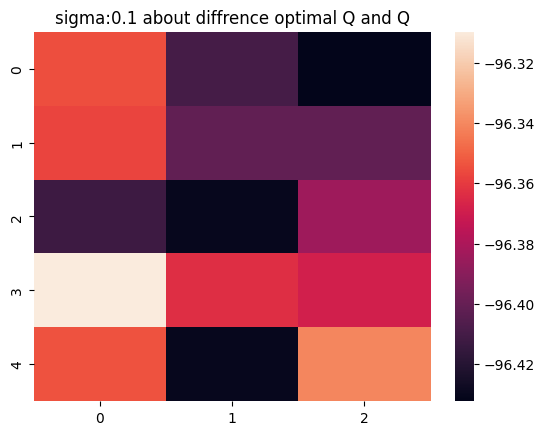

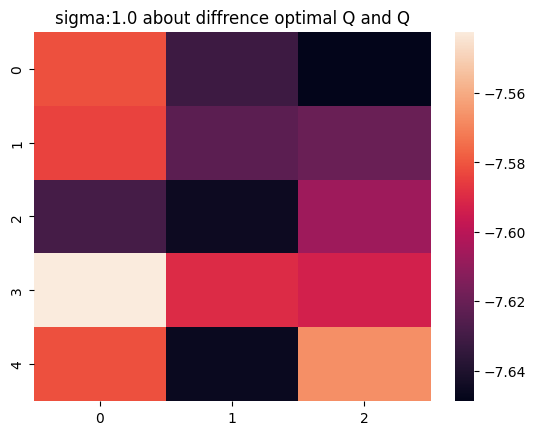

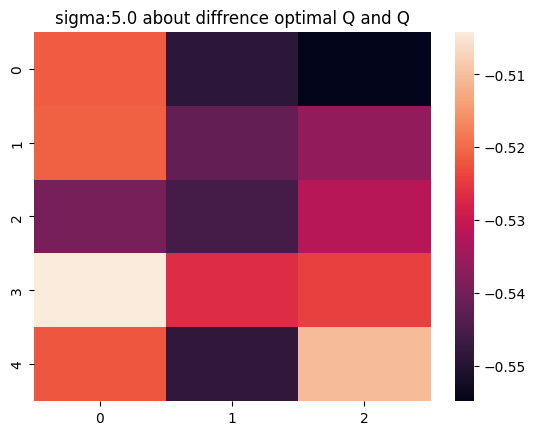

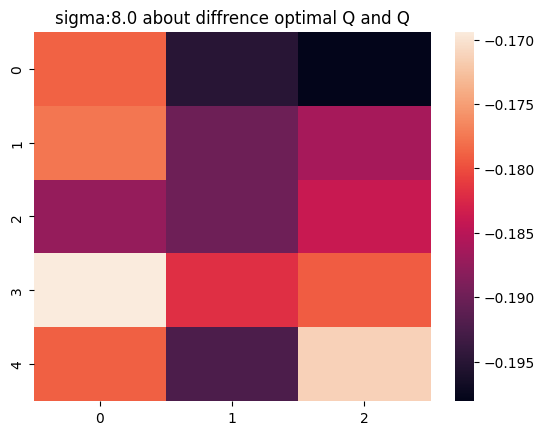

In [40]:
sigmas = [0.1,1.0,5.0,8.0]
Q_list = []

for sigma in sigmas:
    Q = compute_Q(mdp,sigma)
    Q_list.append(Q)


import matplotlib.pyplot as plt
import seaborn as sns
for i, data in enumerate(Q_list):
    sns.heatmap(optimal_Q -Q_list[i])
    plt.title(f"sigma:{sigmas[i]} about diffrence optimal Q and Q")
    plt.show()

$\sigma$が大きくなるにつれて近似誤差は減っていってますね．